In [1]:
import seaborn as sn
import quandl
API_KEY = "yCev-u-joPYss-FULGkt"
quandl.ApiConfig.api_key = (API_KEY)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
from sklearn.metrics import  mean_squared_error
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
def forecast_accuracy(forecast, actual):
    mse = mean_squared_error(actual, forecast)
    return math.sqrt(mse)

Let's retrieve the data

In [4]:
premia_df = quandl.get('HKEX/09151')
print(premia_df.shape)
premia_df.head()

(422, 12)


,Nominal Price,Net Change,Change (%),Bid,Ask,P/E(x),High,Low,Previous Close,Share Volume (000),Turnover (000),Lot Size
Date,,,,,,,,,,,,
2021-07-28,1.488,None,None,1.482,1.488,None,1.520,1.486,1.530,232.0,349.0,None
2021-07-29,1.566,None,None,1.554,NaN,None,1.566,1.530,1.488,25.0,39.0,None
2021-07-30,1.590,None,None,NaN,NaN,None,1.600,1.562,1.566,91.0,143.0,None
2021-08-02,1.576,None,None,1.574,NaN,None,1.590,1.574,1.590,3.0,5.0,None
2021-08-03,1.564,None,None,1.552,1.578,None,1.574,1.562,1.576,1.0,1.0,None


In [5]:
df = pd.DataFrame({'Date': premia_df.index.values,
                          'value': premia_df['Nominal Price']
                          })
df = df.reset_index(drop=True)
print(df.info())
# df.plot()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    422 non-null    datetime64[ns]
 1   value   422 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.7 KB
None


Let's try to predict the Nominal Price with time series

# ARIMA

ADF Test for Null Hypothesis

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.044943
p-value: 0.267221


p-value > 0.05 => Null hypothesis is not true.
Now, to find 'd'

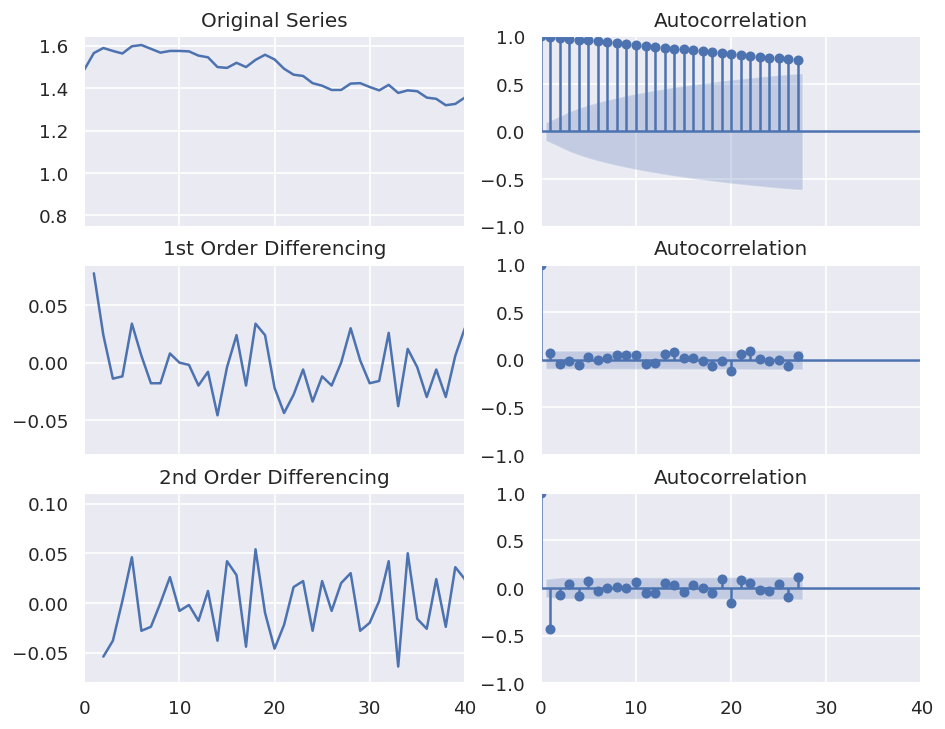

In [7]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
axes[0, 1].set_xlim([0, 40])
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 1].set_xlim([0, 40])
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

d=1, as the dataset becomes stationary at 1st order differencing

Now, to find AR(p)

/home/ananthNB/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


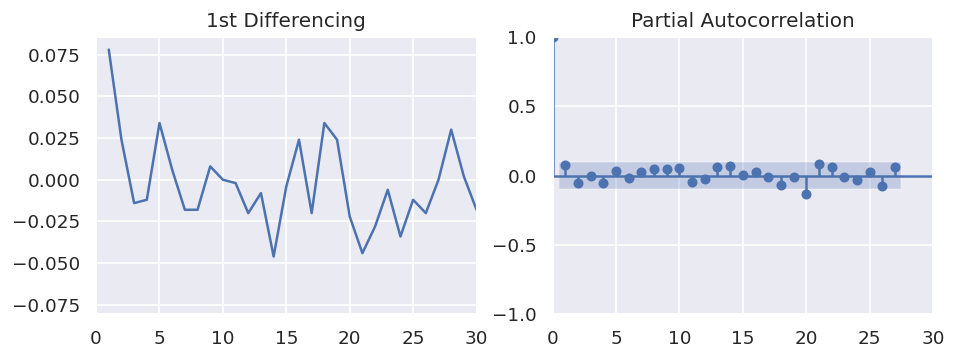

In [8]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,4))
axes[1].set_xlim([0, 30])
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

p = 1

Now, to find MA(q)

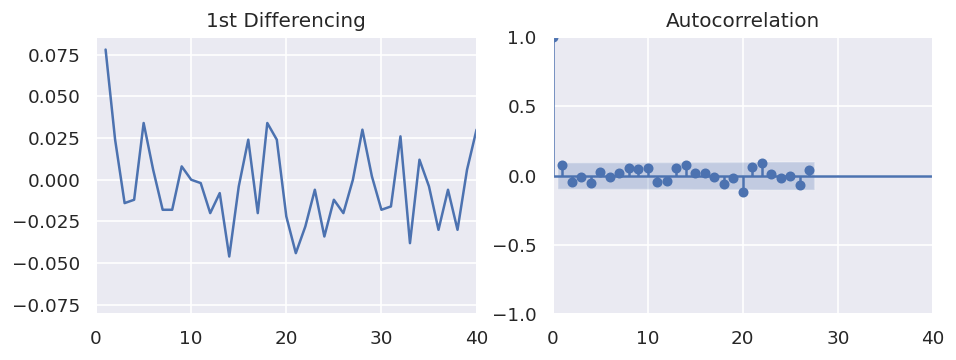

In [9]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

q = 1

Now, to create the model

In [10]:
from statsmodels.tsa.arima.model import ARIMA
train = df[:380]
test = df[380:]
# 1,3,3 ARIMA Model
model = ARIMA(train.value, order=(1,1,1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  380
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 962.490
Date:                Wed, 19 Apr 2023   AIC                          -1918.980
Time:                        02:01:22   BIC                          -1907.168
Sample:                             0   HQIC                         -1914.292
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3624      0.371     -0.977      0.329      -1.090       0.365
ma.L1          0.4676      0.356      1.315      0.189      -0.230       1.165
sigma2         0.0004   1.99e-05     18.309      0.0

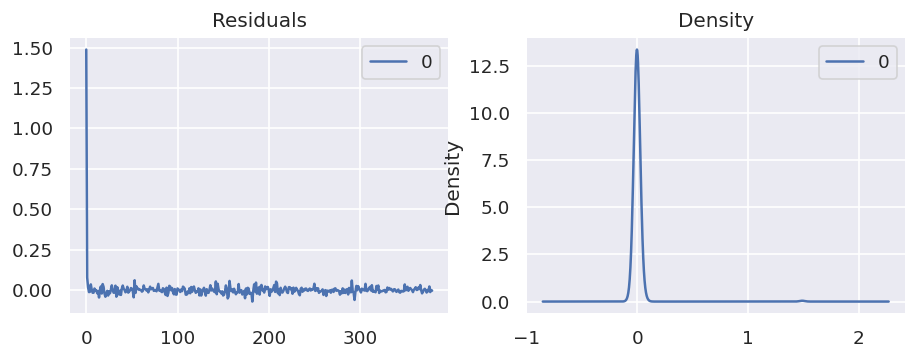

In [11]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

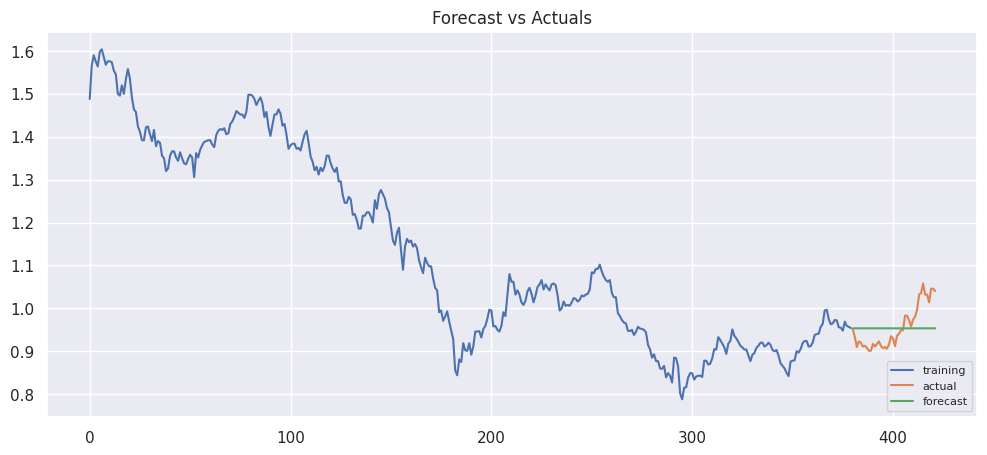

In [12]:
#Forecast
forecast = fitted.predict(start=380, end=421)
# print(forecast)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='training')
plt.plot(test.value, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='lower right', fontsize=8)
plt.show()

Root Mean Squared Error (MSE)

In [13]:
print(forecast_accuracy(forecast,test.value))
# test.value

0.04950982371720974
